# Benchmarking a single image
In this notebook, the template matching algorithm is bench marked

In [1]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
import pyxem.utils.indexation_utils as iut
import pyxem.utils.polar_transform_utils as ptu

In [2]:
# we load a random image, it doesn't matter
dt = hs.load("data/Cu-Ag_alloy-1000max.blo", lazy=True)
image = dt.inav[0, 0].data.compute()  # for the cpu
image_cp = cp.asarray(image)          # for the gpu
del dt

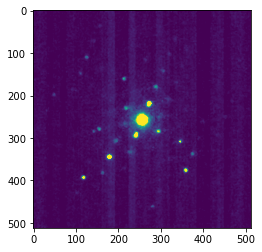

In [3]:
plt.imshow(image, vmax=50)

In [4]:
# this assumes that the copper diffraction library was already calculated in the previous notebook
from diffsims.libraries.diffraction_library import load_DiffractionLibrary
diff_lib = load_DiffractionLibrary("data/Cu_lib_0.3deg_0.1me.pickle", True)

In [5]:
import pyxem.utils.indexation_utils as iutls
import pyxem.utils.polar_transform_utils as ptutls
simulations = diff_lib["cu"]["simulations"]

# Benchmark on CPU

In [8]:
from time import time, sleep
from pyxem.utils import polar_transform_utils as ptutls
n_keep = [1, 500, 1000, 3000, 6000, 10000]
delta_theta = [5, 1, 0.5, 0.2, 0.1]
grids = []

for dt in delta_theta:
    polar_image, r, theta, intensities = iutls._prepare_image_and_templates(
        image,
        simulations,
        delta_r=1,
        delta_theta=dt,
        max_r=250,
        intensity_transform_function=None,
        find_direct_beam=False,
        direct_beam_position=None,
        normalize_image=False,
        normalize_templates=True,
    )
    integrated_templates = iutls._get_integrated_polar_templates(
        polar_image.shape[1],
        r,
        intensities,
        normalize_templates=True,
    )
    for nk in n_keep:
        print(f"nkeep: {nk}, delta: {dt}")
        times = []
        for i in range(10):
            # things we want to time as it needs to be done each image: the time to convert a pattern to polar coordinates, the time to do a quick index, the time to do a full index
            print(i+1, end=" ")
            start = time()
            ptutls.image_to_polar(image, 1, dt, 250, False, None)
            indexes, r_filt, theta_filt, intensities_filt = iutls._prefilter_templates(polar_image, r, theta, intensities, integrated_templates, None, nk)
            angles, cor, angles_m, cor_m = iutls._get_full_correlations(polar_image, r_filt, theta_filt, intensities_filt, (16, 16))
            end = time()
            times.append(end - start)
        grids.append((nk, dt, np.mean(times), np.std(times)))
        print("")
grids = np.array(grids)

nkeep: 1, delta: 5
1 2 3 4 5 6 7 8 9 10 
nkeep: 500, delta: 5
1 2 3 4 5 6 7 8 9 10 
nkeep: 1000, delta: 5
1 2 3 4 5 6 7 8 9 10 
nkeep: 3000, delta: 5
1 2 3 4 5 6 7 8 9 10 
nkeep: 6000, delta: 5
1 2 3 4 5 6 7 8 9 10 
nkeep: 10000, delta: 5
1 2 3 4 5 6 7 8 9 10 
nkeep: 1, delta: 1
1 2 3 4 5 6 7 8 9 10 
nkeep: 500, delta: 1
1 2 3 4 5 6 7 8 9 10 
nkeep: 1000, delta: 1
1 2 3 4 5 6 7 8 9 10 
nkeep: 3000, delta: 1
1 2 3 4 5 6 7 8 9 10 
nkeep: 6000, delta: 1
1 2 3 4 5 6 7 8 9 10 
nkeep: 10000, delta: 1
1 2 3 4 5 6 7 8 9 10 
nkeep: 1, delta: 0.5
1 2 3 4 5 6 7 8 9 10 
nkeep: 500, delta: 0.5
1 2 3 4 5 6 7 8 9 10 
nkeep: 1000, delta: 0.5
1 2 3 4 5 6 7 8 9 10 
nkeep: 3000, delta: 0.5
1 2 3 4 5 6 7 8 9 10 
nkeep: 6000, delta: 0.5
1 2 3 4 5 6 7 8 9 10 
nkeep: 10000, delta: 0.5
1 2 3 4 5 6 7 8 9 10 
nkeep: 1, delta: 0.2
1 2 3 4 5 6 7 8 9 10 
nkeep: 500, delta: 0.2
1 2 3 4 5 6 7 8 9 10 
nkeep: 1000, delta: 0.2
1 2 3 4 5 6 7 8 9 10 
nkeep: 3000, delta: 0.2
1 2 3 4 5 6 7 8 9 10 
nkeep: 6000, delta: 0.2
1

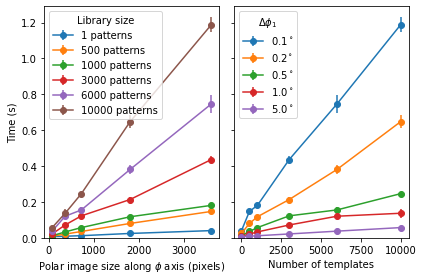

In [9]:
import pandas as pd
grid_df = pd.DataFrame(grids, columns=["nk", "dt", "mean", "std"])

fig, axes = plt.subplots(ncols=2, sharey=True)

ax, ax1 = axes

groups = grid_df.groupby("nk")
for name, group in groups:
    #print(group)
    ax.errorbar(360/group["dt"], group["mean"], yerr=group["std"], label=f"{int(name)} patterns",
                marker="o",
               )
    
ax.set_xlabel(r"Polar image size along $\phi$ axis (pixels)")
ax.set_ylabel("Time (s)")
ax.set_ylim(0,None)
ax.legend(title="Library size")

groups = grid_df.groupby("dt")
for name, group in groups:
    #print(group)
    ax1.errorbar(group["nk"], group["mean"], yerr=group["std"], label=f"{name}"+r"$^\circ$",
                marker="o",
               )
    
ax1.set_xlabel(r"Number of templates")
#ax1.set_ylabel("Time (s)")
#ax1.set_ylim(0,2)
ax1.legend(title=r"$\Delta\phi_1$")
fig.tight_layout()

In [10]:
grid_df.to_csv("data/210921BenchMark.csv")

# GPU benchmarking

In [12]:
from time import time, sleep
from pyxem.utils import polar_transform_utils as ptutls
n_keep = [1, 500, 1000, 3000, 6000, 10000]
delta_theta = [5, 1, 0.5, 0.2, 0.1]
grids_gpu = []

mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

for dt in delta_theta:
    polar_image, r, theta, intensities = iutls._prepare_image_and_templates(
        image,
        simulations,
        delta_r=1,
        delta_theta=dt,
        max_r=250,
        intensity_transform_function=None,
        find_direct_beam=False,
        direct_beam_position=None,
        normalize_image=False,
        normalize_templates=True,
    )
    integrated_templates = iutls._get_integrated_polar_templates(
        polar_image.shape[1],
        r,
        intensities,
        normalize_templates=True,
    )
    r = cp.asarray(r)
    theta = cp.asarray(theta)
    intensities = cp.asarray(intensities)
    integrated_templates = cp.asarray(integrated_templates)
    for nk in n_keep:
        print(f"nkeep: {nk}, delta: {dt}")
        times = []
        for i in range(10):
            # things we want to time as it needs to be done each image: time to send data to the GPU, the time to convert a pattern to polar coordinates, the time to do a quick index, the time to do a full index, time to send back
            print(i+1, end=" ")
            start = time()
            image_cp = cp.asarray(image)          # for the gpu
            polar_image = ptutls.image_to_polar(image_cp, 1, dt, 250, False, None)
            indexes, r_filt, theta_filt, intensities_filt = iutls._prefilter_templates(polar_image, r, theta, intensities, integrated_templates, None, nk)
            angles, cor, angles_m, cor_m = iutls._get_full_correlations(polar_image, r_filt, theta_filt, intensities_filt, (16, 16))
            cp.asnumpy(angles)
            cp.asnumpy(cor)
            cp.asnumpy(angles_m)
            cp.asnumpy(cor_m)
            end = time()
            times.append(end - start)
            # clear the memory pool to not have cache
            mempool.free_all_blocks()
            pinned_mempool.free_all_blocks()
        grids_gpu.append((nk, dt, np.mean(times), np.std(times)))
        print("")
grids_gpu = np.array(grids_gpu)

nkeep: 1, delta: 5
1 2 3 4 5 6 7 8 9 10 
nkeep: 500, delta: 5
1 2 3 4 5 6 7 8 9 10 
nkeep: 1000, delta: 5
1 2 3 4 5 6 7 8 9 10 
nkeep: 3000, delta: 5
1 2 3 4 5 6 7 8 9 10 
nkeep: 6000, delta: 5
1 2 3 4 5 6 7 8 9 10 
nkeep: 10000, delta: 5
1 2 3 4 5 6 7 8 9 10 
nkeep: 1, delta: 1
1 2 3 4 5 6 7 8 9 10 
nkeep: 500, delta: 1
1 2 3 4 5 6 7 8 9 10 
nkeep: 1000, delta: 1
1 2 3 4 5 6 7 8 9 10 
nkeep: 3000, delta: 1
1 2 3 4 5 6 7 8 9 10 
nkeep: 6000, delta: 1
1 2 3 4 5 6 7 8 9 10 
nkeep: 10000, delta: 1
1 2 3 4 5 6 7 8 9 10 
nkeep: 1, delta: 0.5
1 2 3 4 5 6 7 8 9 10 
nkeep: 500, delta: 0.5
1 2 3 4 5 6 7 8 9 10 
nkeep: 1000, delta: 0.5
1 2 3 4 5 6 7 8 9 10 
nkeep: 3000, delta: 0.5
1 2 3 4 5 6 7 8 9 10 
nkeep: 6000, delta: 0.5
1 2 3 4 5 6 7 8 9 10 
nkeep: 10000, delta: 0.5
1 2 3 4 5 6 7 8 9 10 
nkeep: 1, delta: 0.2
1 2 3 4 5 6 7 8 9 10 
nkeep: 500, delta: 0.2
1 2 3 4 5 6 7 8 9 10 
nkeep: 1000, delta: 0.2
1 2 3 4 5 6 7 8 9 10 
nkeep: 3000, delta: 0.2
1 2 3 4 5 6 7 8 9 10 
nkeep: 6000, delta: 0.2
1

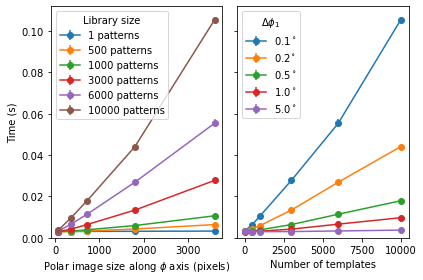

In [13]:
import pandas as pd
grid_df_gpu = pd.DataFrame(grids_gpu, columns=["nk", "dt", "mean", "std"])

fig, axes = plt.subplots(ncols=2, sharey=True)

ax, ax1 = axes

groups = grid_df_gpu.groupby("nk")
for name, group in groups:
    #print(group)
    ax.errorbar(360/group["dt"], group["mean"], yerr=group["std"], label=f"{int(name)} patterns",
                marker="o",
               )
    
ax.set_xlabel(r"Polar image size along $\phi$ axis (pixels)")
ax.set_ylabel("Time (s)")
ax.set_ylim(0,None)
ax.legend(title="Library size")

groups = grid_df_gpu.groupby("dt")
for name, group in groups:
    #print(group)
    ax1.errorbar(group["nk"], group["mean"], yerr=group["std"], label=f"{name}"+r"$^\circ$",
                marker="o",
               )
    
ax1.set_xlabel(r"Number of templates")
#ax1.set_ylabel("Time (s)")
#ax1.set_ylim(0,2)
ax1.legend(title=r"$\Delta\phi_1$")
fig.tight_layout()

In [14]:
grid_df_gpu.to_csv("data/210921BenchMark_gpu.csv")

# Combined insight

In [18]:
grid_df = pd.read_csv("data/210921BenchMark.csv")
grid_df_gpu = pd.read_csv("data/210921BenchMark_gpu.csv")

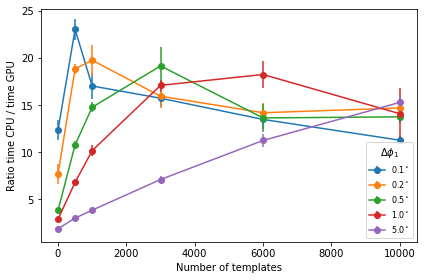

In [19]:
fig, ax = plt.subplots()

groups_1 = grid_df.groupby("dt")
for name, group_1 in groups_1:
    #print(group)
    group_2 = grid_df_gpu[grid_df_gpu["dt"] == name]
    values = group_1["mean"]/group_2["mean"]
    errors = np.sqrt((group_1["std"]/group_1["mean"])**2 + (group_2["std"]/group_2["mean"])**2)*values
    ax.errorbar(group["nk"], values, yerr=errors, label=f"{name}"+r"$^\circ$",
                marker="o",
               )
    
ax.set_xlabel(r"Number of templates")
ax.set_ylabel("Ratio time CPU / time GPU")
#ax.set_ylim(0,1.3)
ax.legend(title=r"$\Delta\phi_1$", loc="lower right", fontsize=8)
fig.tight_layout()

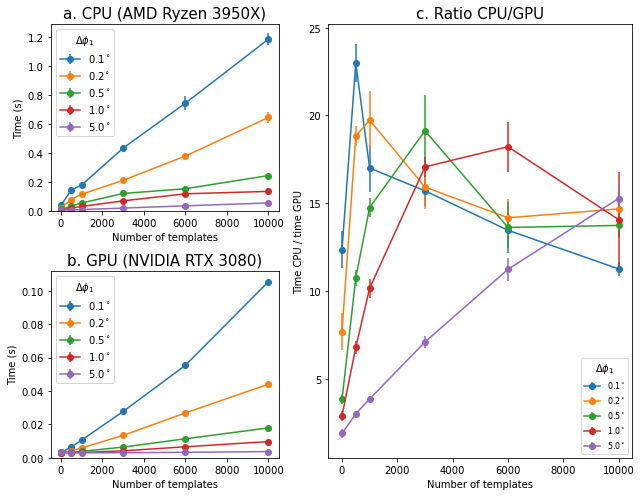

In [20]:
import matplotlib.gridspec as gridspec

fig = plt.figure(tight_layout=True, figsize=(9, 7))
gs = gridspec.GridSpec(2, 2, width_ratios=(3, 4))

ax = fig.add_subplot(gs[0, 0])
groups = grid_df.groupby("dt")
for name, group in groups:
    #print(group)
    ax.errorbar(group["nk"], group["mean"], yerr=group["std"], label=f"{name}"+r"$^\circ$",
                marker="o",
               )
ax.set_xlabel(r"Number of templates")
ax.set_ylabel("Time (s)")
ax.set_title("a. CPU (AMD Ryzen 3950X)", fontsize=15)
ax.set_ylim(0,None)
ax.legend(title=r"$\Delta\phi_1$", loc="upper left")
fig.tight_layout()

ax1 = fig.add_subplot(gs[1, 0])
groups = grid_df_gpu.groupby("dt")
for name, group in groups:
    #print(group)
    ax1.errorbar(group["nk"], group["mean"], yerr=group["std"], label=f"{name}"+r"$^\circ$",
                marker="o",
               )
    
ax1.set_xlabel(r"Number of templates")
ax1.set_ylabel("Time (s)")
ax1.set_title("b. GPU (NVIDIA RTX 3080)", fontsize=15)
ax1.legend(title=r"$\Delta\phi_1$", loc="upper left")
ax1.set_ylim(0,None)
fig.tight_layout()

ax2 = fig.add_subplot(gs[:, 1])
groups_1 = grid_df.groupby("dt")
for name, group_1 in groups_1:
    #print(group)
    group_2 = grid_df_gpu[grid_df_gpu["dt"] == name]
    values = group_1["mean"]/group_2["mean"]
    errors = np.sqrt((group_1["std"]/group_1["mean"])**2 + (group_2["std"]/group_2["mean"])**2)*values
    ax2.errorbar(group["nk"], values, yerr=errors, label=f"{name}"+r"$^\circ$",
                marker="o",
               )
    
ax2.set_xlabel(r"Number of templates")
ax2.set_ylabel("Time CPU / time GPU")
ax2.set_title("c. Ratio CPU/GPU", fontsize=15)
#ax.set_ylim(0,1.3)
ax2.legend(title=r"$\Delta\phi_1$", loc="lower right", fontsize=8)

In [21]:
fig.savefig("210903DataImages/210910BenchMarks.png", dpi=640)